In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

'2.3.0+cu121'

In [4]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 15713, done.
remote: Counting objects: 100% (436/436), done.
remote: Compressing objects: 100% (325/325), done.
remote: Total 15713 (delta 196), reused 292 (delta 105), pack-reused 15277
Receiving objects: 100% (15713/15713), 6.51 MiB | 18.57 MiB/s, done.
Resolving deltas: 100% (11311/11311), done.
Obtaining file:///content/detectron2_repo
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 771.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("coins", {}, "/content/drive/MyDrive/Colab Notebooks/Detectron2/train/_annotations.coco.json", "/content/drive/MyDrive/Colab Notebooks/Detectron2/train/")

In [3]:
coins_metadata = MetadataCatalog.get("coins")
dataset_dicts = DatasetCatalog.get("coins")

WARNING [05/29 22:37:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/29 22:37:23 d2.data.datasets.coco]: Loaded 194 images in COCO format from /content/drive/MyDrive/Colab Notebooks/Detectron2/train/_annotations.coco.json


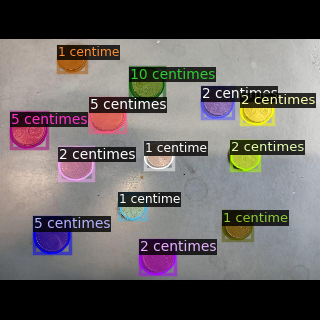

TypeError: 'NoneType' object is not subscriptable

In [4]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=coins_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("coins",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 800    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 150   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [22]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()

cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Colab Notebooks/Detectron2/output/model/model.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("coins", )
predictor = DefaultPredictor(cfg)

[05/29 22:47:53 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Colab Notebooks/Detectron2/output/model/model.pth ...


backbone.res2.0.conv1.norm.{bias, weight}
backbone.res2.0.conv1.weight
backbone.res2.0.conv2.norm.{bias, weight}
backbone.res2.0.conv2.weight
backbone.res2.0.conv3.norm.{bias, weight}
backbone.res2.0.conv3.weight
backbone.res2.0.shortcut.norm.{bias, weight}
backbone.res2.0.shortcut.weight
backbone.res2.1.conv1.norm.{bias, weight}
backbone.res2.1.conv1.weight
backbone.res2.1.conv2.norm.{bias, weight}
backbone.res2.1.conv2.weight
backbone.res2.1.conv3.norm.{bias, weight}
backbone.res2.1.conv3.weight
backbone.res2.2.conv1.norm.{bias, weight}
backbone.res2.2.conv1.weight
backbone.res2.2.conv2.norm.{bias, weight}
backbone.res2.2.conv2.weight
backbone.res2.2.conv3.norm.{bias, weight}
backbone.res2.2.conv3.weight
backbone.res3.0.conv1.norm.{bias, weight}
backbone.res3.0.conv1.weight
backbone.res3.0.conv2.norm.{bias, weight}
backbone.res3.0.conv2.weight
backbone.res3.0.conv3.norm.{bias, weight}
backbone.res3.0.conv3.weight
backbone.res3.0.shortcut.norm.{bias, weight}
backbone.res3.0.shortcut.w

In [ ]:
from detectron2.utils.visualizer import ColorMode


im = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Detectron2/test/101.jpg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                   metadata=coins_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
            )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

## Benchmark inference speed

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.11,fps:9.45
